<a href="https://colab.research.google.com/github/RaminParker/Custom_Image_Classifier/blob/master/Custom_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a custom image classifier for free and use it in your side projects! 

In this notebook, you'll: 

1. Install and import fastai in 3 LOC
2. Create your own dataset from scratch with images of anything you want in 4 LOC
3. Train your very own and very serious _deep neural network_ in 5-ish LOC
4. Take a look at how it works visually, what it gets right and wrong in just 1 LOC
5. Make predictions with your new model on arbitrary images in 2 LOC (one line is to fetch the image file, soooo)
6. Save your model so that you can then use it in any Python code (1 LOC to save, 1 to load)
7. Add-on: get a snippet of 4 lines of Flask code that'll run a neural net over an HTTP API. 


If you just want to create the neural net for custom image categories — just set the `labels` you want in [cell 4](https://colab.research.google.com/drive/1pby4ihKOK0kOdXttbDJV_8flIKmSEKQ4#scrollTo=K5-pl0y5h47q), then run the notebook. 

If you want more training examples, tweak `n_images`, but if you want 100+ images, you'll have to install chromedriver on google collab and that's outside of the scope of this demo. 

## Installing fastai from git 

You'll have to run this cell every time you restart the Collab envorinment, it's not persisted, and fastai is not available by default. 

In [0]:
!pip install https://github.com/fastai/fastai/archive/master.zip

In [0]:
from fastai.vision import *
from fastai.widgets import *

## Fetch your own custom dataset!

First we'll fetch some images for 2 categories from google search. Cat breeds will work nicely ;-)

In [0]:
path = Path('data/cat-breeds')
labels = ['maine coon', 'bengal cat', 'persian cat', 'siamese cat', 'sphynx cat']
n_images = 100
src_img_size='>800*600'

In [0]:
for l in labels:
  download_google_images(path, l, n_images=n_images, size=src_img_size)

This should give us two directories (`maine coon` and `bengal cat`) with about 100 images in each. 

In [0]:
path.ls()

[PosixPath('data/cat-breeds/siamese cat'),
 PosixPath('data/cat-breeds/bengal cat'),
 PosixPath('data/cat-breeds/sphynx cat'),
 PosixPath('data/cat-breeds/persian cat'),
 PosixPath('data/cat-breeds/maine coon')]

## Prepare a databunch 

We'll set up a `databunch` using the data block API.

In [0]:
bs = 64
size = 224

In [0]:
src = (ImageItemList.from_folder(path).
      random_split_by_pct(.2).
      label_from_folder().
      transform(get_transforms(), size=size))

In [0]:
data = src.databunch(bs=bs)

Then we'll setup a learner with resnet50 and fit it for a few epochs.

In [0]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

## Train for a bit

In [0]:
learn.lr_find()

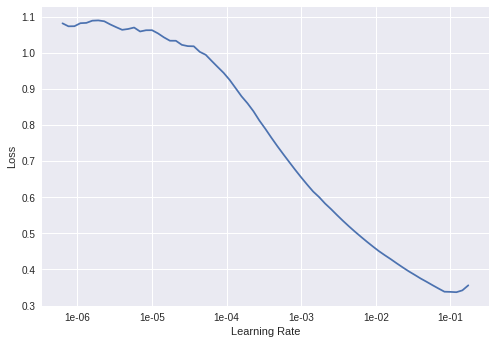

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy
1,1.208408,0.571373,0.851852
2,0.664166,0.264018,0.962963
3,0.459788,0.227868,0.962963
4,0.338566,0.213222,0.962963
5,0.269640,0.212070,0.950617


In [0]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.063722,0.215588,0.950617
2,0.062285,0.218717,0.950617
3,0.070385,0.222641,0.950617


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find(); learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.042374,0.225094,0.950617
2,0.066533,0.231191,0.950617
3,0.058532,0.232509,0.950617
4,0.061086,0.227274,0.950617
5,0.067465,0.228911,0.950617
6,0.062652,0.229992,0.950617
7,0.061644,0.228359,0.950617
8,0.056219,0.232184,0.950617
9,0.057300,0.229399,0.950617
10,0.056171,0.228768,0.950617


In [0]:
learn.save('catbreeds-resnet50')

In [0]:
learn.load('catbreeds-resnet50');

## Interpreting the results

Let's see what our model is wrong about:

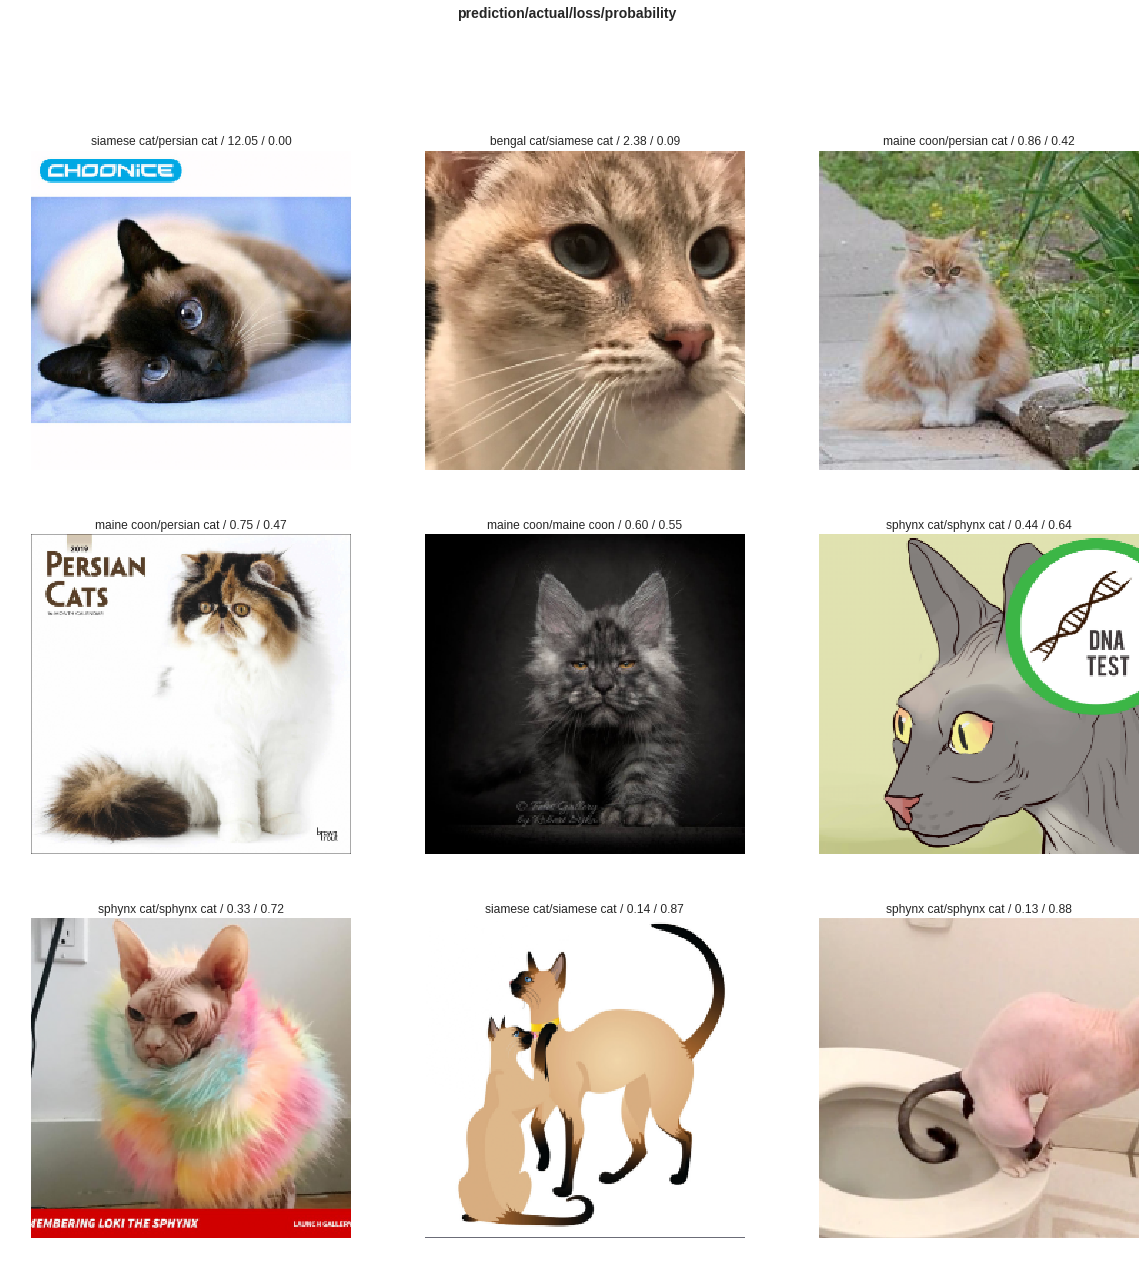

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20, 20))

There obviously are some weird images that are not really cats. 

Funny thing is if you clean up the images that don't belong in your dataset, the validation accuracy will jump to 100%. Some of the pics displayed by `plot_top_losses` got correct labels, but low certainty.

## Exporting the whole learner

This is new in fastai 1.0.40dev — you can now export whole learner and then recreate it without building the databunch and setting up all the params like `size`, `bs` and others. 

In [0]:
learn.export('catbreeds-export.pkl')

**Run the next cell to download your model! **

In [0]:
# Run this cell to download the model to your computer! 

from google.colab import files

files.download(path/'catbreeds-export.pkl')

# To use the model in your own code, do this: 

# from fastai.vision import * 
# learn = load_learner(path_to_downloaded_file)
# learn.predict(image_file_opened_with_PIL)

## Classifying an image

So you have a pic of a cat and you're not sure what breed it is. AI to the rescue :trollface:

First off, after `from fastai.vision import *` you need just one line to load the learner object.

In [0]:
loaded = load_learner(path, 'catbreeds-export.pkl')

And now you're ready to run predictions! 

In [0]:
image = data.valid_ds.x[5]
label = data.valid_ds.y[5]

In [0]:
guessed_label, probs, _ = loaded.predict(image)

In [0]:
guessed_label

Category siamese cat

In [0]:
label

Category siamese cat

## Using the classifier in your side project (i.e. production)

To use this in a side project, you probably want to pack it in a simple Flask app or something: ![alt text](https://)

In [0]:
# from flask import Flask, jsonify, request
# from urllib.request import urlretrieve
# 
# from fastai.vision import * 

# path  = Path('data')
# model = load_learner(data/'model/catbreeds-export.pkl')
# app   = Flask(__name__)

# @app.route("/pred")
# def pred():
#     img_url = request.args.get('img')
#     img_fname = img_url.split("/")[-1]
#     urlretrieve(pic_url, path/img_fname)
#     img = open_image(path/img_fname)
#     pred, _ , _ = model.predict(img)
#     return jsonify(img=img_url, label=pred)